In [33]:
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
#img_cl1 = cv.imread('/home/martin/container/data/fake_hail/20220330_LOM/DJI_202203301112_015_Mapping5/Clusters/cluster1.png')
#img_cl2 = cv.imread('/home/martin/container/data/fake_hail/20220330_LOM/DJI_202203301112_015_Mapping5/Clusters/cluster2.png')
img_cluster = cv2.imread('/home/martin/container/data/fake_hail/20220330_LOM/DJI_202203301112_015_Mapping5/JPG_pp3_green/tiles/clusters/tmp/cluster_500px.png')

imgHLS = cv2.cvtColor(img_cluster, cv2.COLOR_BGR2HLS)
Lchannel = imgHLS[:,:,1]
mask = cv2.inRange(Lchannel, 200, 255)
res = cv2.bitwise_and(img_cluster,img_cluster, mask= mask)

#gray = cv.cvtColor(img_cluster,cv.COLOR_BGR2GRAY)
#ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

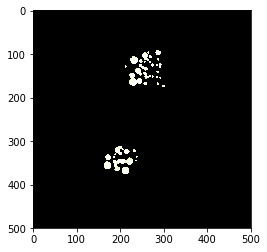

In [9]:
plt.imshow(res)

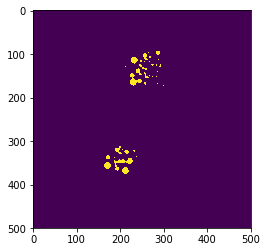

In [48]:
# noise removal
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=1)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(sure_fg)
plt.show()

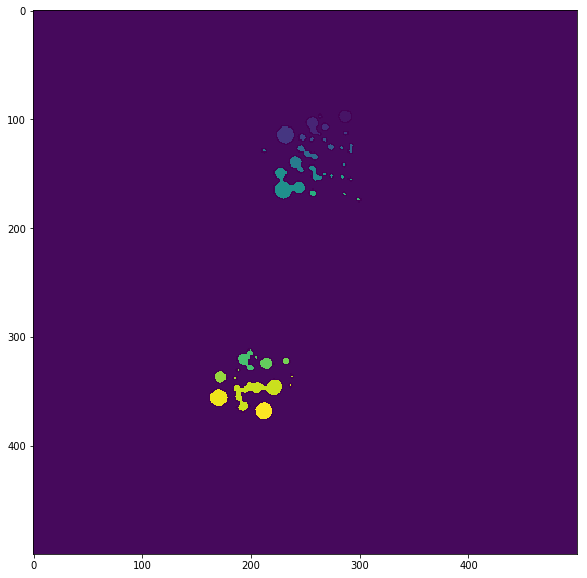

In [49]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.subplots(figsize=[10,10])
plt.imshow(markers)
plt.show()

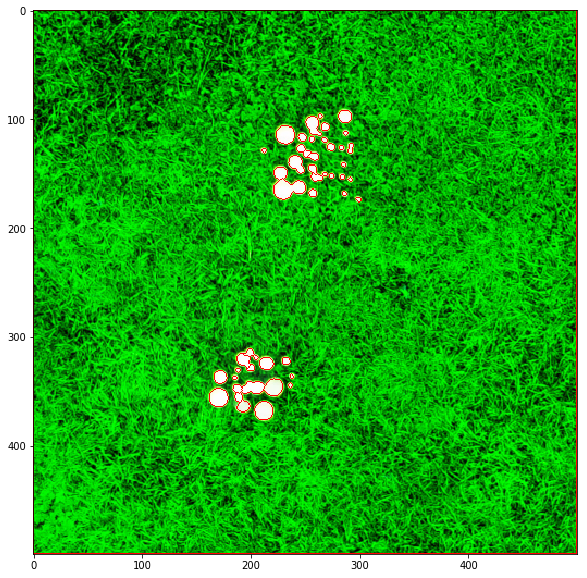

In [50]:
markers = cv2.watershed(img_cluster,markers)
img_cluster[markers == -1] = [255,0,0]
plt.subplots(figsize=[10,10])
plt.imshow(img_cluster)
plt.show()

In [46]:
#Retrieve object/hail major and minor axes sizes
from bbox.min_bounding_rect import minBoundingRect
major_size = []
minor_size = []
gsd = 1.5

for mi, m in enumerate(np.unique(markers)):
    
    mask_co = np.where(markers == m)
    x=mask_co[0]
    y=mask_co[1]
    cart_co=[]
    for i, xval in enumerate(x):
        cart_co.append((xval,y[i]))
    
    (rot_angle, area, width, height, center_point, box) = minBoundingRect(np.asarray(cart_co))

    #Hail major axes and minor axes size from box
    major_size_tmp = np.max([width,height]) * gsd
    minor_size_tmp = np.min([width,height]) * gsd
    major_size.append(major_size_tmp)
    minor_size.append(minor_size_tmp)

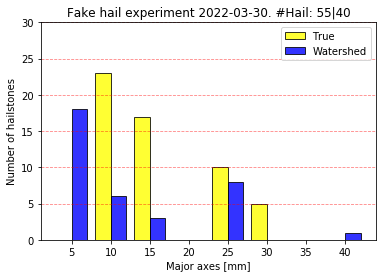

In [47]:
#Plot real verus Watershed distribution of fake-hail cluster
S10 = np.ones(23)*10
S15 = np.ones(17)*15
S25 = np.ones(10)*25
S30 = np.ones(5)*30
data_true = np.concatenate([S10,S15,S25,S30])
n_hail_true=np.size(data_true)

data = np.asarray(major_size)
n_hail=np.size(data)

fig = plt.figure()
ax = fig.add_subplot(111)
numBins = 8
bins = ax.hist([data_true,data],numBins,range=[2.5,42.5],color=['yellow','blue'],alpha=0.8, edgecolor='black',label=['True','Watershed'])

#ax.hist(data,numBins,range=[2.5,42.5],color='blue',alpha=0.8, edgecolor='black')
plt.title('Fake hail experiment 2022-03-30. #Hail: '+str(n_hail_true)+'|'+str(n_hail))
plt.ylim([0,30])
plt.grid(axis='y',color='red',linestyle='--',alpha=0.5)
plt.ylabel('Number of hailstones')
plt.xlabel('Major axes [mm]')
plt.legend(loc='upper right')
plt.show()